<a href="https://colab.research.google.com/github/dave502/NLP/blob/main/%20lesson_07/nlp_hw_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install xlrd --upgrade
!pip install stop_words
!pip install pymorphy2
!pip install fasttext

In [8]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [9]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard, EarlyStopping

In [ ]:
!pip install navec
!pip install slovnet
from navec import Navec
from slovnet.model.emb import NavecEmbedding
import gensim, logging

In [ ]:
# библиотеку Navec не удалось использовать для tensorflow

# !wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
# path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
# navec = Navec.load(path) 

In [ ]:
# загружаем предобученную модель 
!wget http://vectors.nlpl.eu/repository/20/220.zip
!unzip '220.zip' -d emb_model

In [10]:
pd.set_option('max_colwidth', 148)
random_state=42

Функция предобработки текста

In [11]:
morpher = MorphAnalyzer()
stopwords = set(get_stop_words("ru")) - {'не', 'нет', 'хорошо'}

def preprocess_text(text: pd.Series)->pd.Series:
  """
  функция обработки текста для pandas.Series
  """  
  # регулярное выражение для очистки текста
  url_pattern = "(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])"
  #punct_pattern = f"[{punct+'«—»'}]"
  smile_pattern = "(:D|D:)"
  usernames_pattern = "(@[\w]*|RT @[\w]*)"
  onlywords_pattern = "[^\w\b]|[^A-Za-zА-ЯЁа-яё]"
  pattern = f"{smile_pattern}|{url_pattern}|{usernames_pattern}|{onlywords_pattern}"

  # удаление лишних символов в соответствии с регулярными выражениями 
  new_text = text.replace(pattern, ' ', regex=True)
  
  # совмещение отрицаний 'не'/'нет' со следующим словом
  new_text = new_text.replace(r'((?<=[\s]не)|(?<=^Не))\s(?=[\w])', '')

  # лемматизация, удаление стоп-слов и запись результата в новую колонку
  new_text = new_text.apply(lambda x: [morpher.normal_forms(token)[0].strip().lower() for token in str(x).split()\
                                            if (token not in stopwords) and (len(token) > 2)])
  return new_text

Функция преобразования слов в токены

In [28]:
def text_to_sequence(text, maxlen, vocabulary):
  
    result = [vocabulary[word] for word in text if word in vocabulary]

    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

Загрузка данных в датафрейм

In [14]:
df = pd.read_excel('data.xls')
df.sample(10)

,Rating,Content,Date
3053,2,постоянно мониторит твой телефон собирает отебе всю информациб и постоянно разводит на кредит,2017-08-09
14557,5,Это хорошее преложение,2017-07-23
14453,5,Супер,2017-07-23
13025,5,Нравится,2017-07-26
4438,1,Идиотская проверка на оригинальность прошивки!,2017-08-07
1921,4,Спасибо,2017-08-11
7069,5,Збсь,2017-08-04
5404,4,Добротное и очень полезное приложение,2017-08-06
4595,1,"Не могу установить из-за ошибки 491, что делать?",2017-08-07
2719,5,Отлично!,2017-08-10


Разбиение данных на обучающий и тестовый наборы

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df['Content'], df['Rating'], test_size=0.2, random_state=random_state)

# # посмотрим получившиеся размеры
# print('Train/val/test sizes')
# pd.DataFrame([[len(X_train), len(y_train)], [len(X_val), len(y_val)], [len(X_test), len(y_test)]], columns=['X', 'y'], \
#              index=['train', 'val', 'test'])

Предобработка обучающей выборки

In [16]:
X_train = preprocess_text(X_train)

In [18]:
X_train.sample(10)

33                                                                          [работать, поиск, наименование, служба]
6663                                                                                                [очень, удобно]
4717                                                                              [вход, дважды, вводить, пин, код]
9180     [приложение, работать, перезагрузка, переустановка, приложение, телефон, помогать, пароль, смс, приходить]
13080                                                                                                      [удобно]
14559                                                                                                            []
10929                                                                                               [маэстро, kart]
13306                                                                                                       [норма]
16958                                                                   

Получение словаря { < слово > : < id > } из обучающей выборки

In [19]:
corpus = X_train.apply(' '.join).to_string(index=False).split()
vocabulary = {v: k for k, v in dict(enumerate(corpus, 1)).items()}

Токенизация обучающей выборки на основании словаря

In [29]:
max_len = 40
x_train = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in X_train], dtype=np.int32)

Преобразование оценок в обучающей выборке в 3 класса: отрицательно, нейтрально и положительно. И категоризация классов.

In [175]:
y_train[y_train<3] = -1
y_train[y_train==3] = 0
y_train[y_train>3] = 1
y_train = keras.utils.to_categorical(y_train, 3)

Препроцессинг и токенизация тестовой выборки

In [176]:
X_test = preprocess_text(X_test)
x_test = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in X_test], dtype=np.int32)

Преобразование оценок в тестовой выборке в 3 класса: отрицательно, нейтрально и положительно. И категоризация классов.

In [177]:
y_test[y_test<3] = -1
y_test[y_test==3] = 0
y_test[y_test>3] = 1
y_test = keras.utils.to_categorical(y_test, 3)

Построение модели

In [60]:
## Define the embedding dimension
EMBEDDING_DIM = 128
MAX_LENGTH = 40
BATCH_SIZE=64
EPOCHS = 20

model = Sequential()
model.add(Embedding(input_dim = len(corpus)+1, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(3)) # количество классов
model.add(Activation('softmax'))

In [52]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Обучение модели

In [56]:
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss', patience=3)  

history = model.fit(x_train, y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_split=0.2,
                    callbacks=[tensorboard, early_stopping])

Epoch 1/20
207/207 [==============================] - 2s 10ms/step - loss: 0.0193 - accuracy: 0.9949 - val_loss: 0.9495 - val_accuracy: 0.8606
Epoch 2/20
207/207 [==============================] - 2s 9ms/step - loss: 0.0185 - accuracy: 0.9950 - val_loss: 0.9477 - val_accuracy: 0.8600
Epoch 3/20
207/207 [==============================] - 2s 10ms/step - loss: 0.0188 - accuracy: 0.9946 - val_loss: 0.9735 - val_accuracy: 0.8621
Epoch 4/20
207/207 [==============================] - 2s 9ms/step - loss: 0.0190 - accuracy: 0.9953 - val_loss: 0.9779 - val_accuracy: 0.8600
Epoch 5/20
207/207 [==============================] - 2s 10ms/step - loss: 0.0184 - accuracy: 0.9952 - val_loss: 0.9971 - val_accuracy: 0.8612


Предикт и вывод метрик

In [58]:
pred = model.predict(x_test, batch_size=BATCH_SIZE, verbose=1)

65/65 [==============================] - 0s 3ms/step


f1_score = 0.8558142194931584


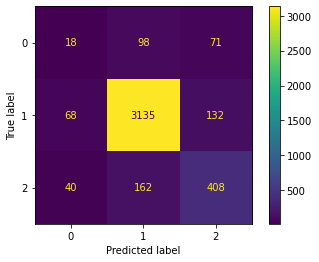

In [75]:
# метрики
matrix = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix) 
cm_display.plot()
print(f'f1_score = {f1_score(y_test.argmax(axis=1), pred.argmax(axis=1), average="weighted")}')

*Метрики хорошие. Хоть модель и не все классы хорошо распознаёт, но по основному классу результаты хорошие*

##### Модель с предобученным эмбеддингом

Загрузка модели из файла

In [126]:
gensim_model = gensim.models.KeyedVectors.load_word2vec_format('emb_model/model.bin', binary=True)

Получение объекта эмбеддинга

In [183]:
gensim_emb = gensim_model.get_keras_embedding(train_embeddings=False)

Построение модели с полученным эмбеддингом в первом слое

In [184]:
## Define the embedding dimension
BATCH_SIZE=64
EPOCHS = 20

model1 = Sequential()
model1.add(gensim_emb) 
model1.add(Conv1D(128, 3))
model1.add(Activation("relu"))
model1.add(GlobalMaxPool1D())
model1.add(Dense(10))
model1.add(Activation("relu"))
model1.add(Dense(3)) # количество классов
model1.add(Activation('softmax'))

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Обучение модели

In [189]:
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss', patience=3)  

history = model1.fit(x_train, y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_split=0.2,
                    callbacks=[tensorboard, early_stopping])

Epoch 1/20
207/207 [==============================] - 15s 73ms/step - loss: 0.1889 - accuracy: 0.9201 - val_loss: 0.4141 - val_accuracy: 0.8606
Epoch 2/20
207/207 [==============================] - 16s 79ms/step - loss: 0.1603 - accuracy: 0.9312 - val_loss: 0.4319 - val_accuracy: 0.8696
Epoch 3/20
207/207 [==============================] - 15s 73ms/step - loss: 0.1393 - accuracy: 0.9454 - val_loss: 0.4342 - val_accuracy: 0.8621
Epoch 4/20
207/207 [==============================] - 16s 79ms/step - loss: 0.1333 - accuracy: 0.9558 - val_loss: 0.4550 - val_accuracy: 0.8693


Предикт и метрика

65/65 [==============================] - 2s 23ms/step
f1_score = 0.8589721492021285


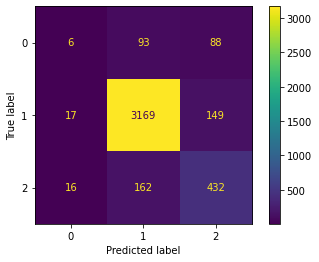

In [190]:
pred = model1.predict(x_test, batch_size=BATCH_SIZE, verbose=1)

# метрики
matrix = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix) 
cm_display.plot()
print(f'f1_score = {f1_score(y_test.argmax(axis=1), pred.argmax(axis=1), average="weighted")}')

*Результат модели с обучающимся эмбеддинг-слоем почти не отличается от результата модели с предобученным эмбеддинг слоем. Разница метрики f1 не превышает 0.01*